In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configurar visualizaciones
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

viridis = cm.get_cmap('viridis', 256)
magma = cm.get_cmap('magma', 256)
plasma = cm.get_cmap('plasma', 256)

In [3]:
df = pd.read_csv(r'C:\Users\demst\Desktop\terremotos\all_month.csv')

In [4]:
df.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-05-02T02:50:02.380Z,33.912167,-117.070000,12.69,0.89,ml,33.0,116.0,NaN,0.20,...,2025-05-02T02:53:47.574Z,"9 km S of Calimesa, CA",earthquake,0.31,1.31,0.167,28.0,automatic,ci,ci
1,2025-05-02T02:39:31.940Z,33.073667,-116.801333,9.34,0.82,ml,5.0,168.0,0.1396,0.15,...,2025-05-02T02:42:55.817Z,"7 km ENE of Ramona, CA",earthquake,3.87,10.42,0.388,9.0,automatic,ci,ci


In [5]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,10137.000000,10137.000000,10137.000000,10137.000000,8661.000000,8661.000000,8659.000000,10137.000000,8046.000000,10137.000000,8644.000000,8660.000000
mean,38.731782,-106.940775,20.288255,1.519695,23.452719,111.266649,0.434701,0.258716,1.706322,2.186346,0.177142,19.206928
std,17.984444,73.009765,50.234703,1.279802,22.620950,64.132831,1.579085,0.271471,3.264264,5.142015,0.103722,33.116053
min,-65.172700,-179.930800,-3.410000,-1.320000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.531000,-146.793600,3.000000,0.720000,9.000000,64.000000,0.014770,0.080000,0.250000,0.450000,0.110000,7.000000
50%,38.811165,-121.076667,7.400000,1.260000,17.000000,94.000000,0.052140,0.160000,0.416988,0.720000,0.160000,12.000000
75%,51.276000,-115.607667,13.800000,1.970000,29.000000,146.000000,0.117050,0.330000,0.950000,1.643410,0.219056,22.000000
max,86.322700,179.999300,642.872000,6.900000,400.000000,359.000000,42.272000,3.830000,41.690000,68.600000,2.090000,802.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10137 entries, 0 to 10136
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             10137 non-null  object 
 1   latitude         10137 non-null  float64
 2   longitude        10137 non-null  float64
 3   depth            10137 non-null  float64
 4   mag              10137 non-null  float64
 5   magType          10137 non-null  object 
 6   nst              8661 non-null   float64
 7   gap              8661 non-null   float64
 8   dmin             8659 non-null   float64
 9   rms              10137 non-null  float64
 10  net              10137 non-null  object 
 11  id               10137 non-null  object 
 12  updated          10137 non-null  object 
 13  place            10137 non-null  object 
 14  type             10137 non-null  object 
 15  horizontalError  8046 non-null   float64
 16  depthError       10137 non-null  float64
 17  magError    

In [7]:
df.isnull().sum() / df.shape[0] * 100

time                0.000000
latitude            0.000000
longitude           0.000000
depth               0.000000
mag                 0.000000
magType             0.000000
nst                14.560521
gap                14.560521
dmin               14.580251
rms                 0.000000
net                 0.000000
id                  0.000000
updated             0.000000
place               0.000000
type                0.000000
horizontalError    20.627405
depthError          0.000000
magError           14.728223
magNst             14.570386
status              0.000000
locationSource      0.000000
magSource           0.000000
dtype: float64

<Axes: >

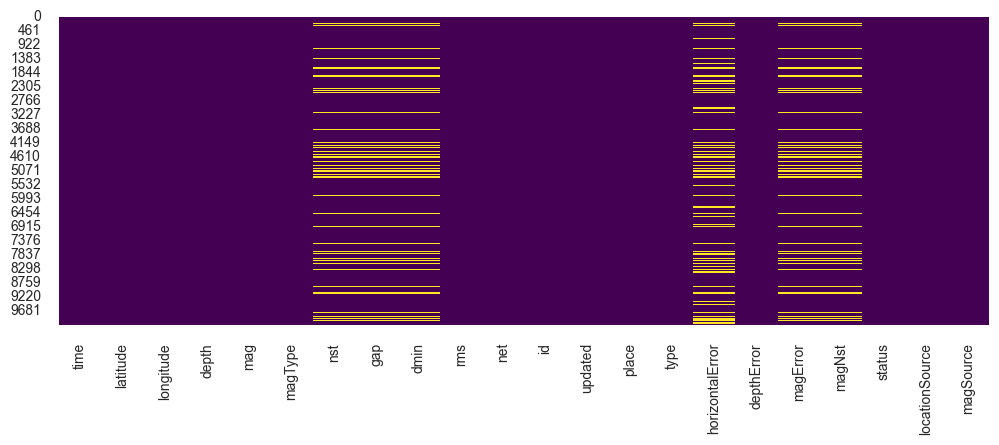

In [8]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

In [9]:
#convertir la columna time a datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

In [10]:
#conversion de columnas nuevas 
df['año'] = df['time'].dt.year
df['mes'] = df['time'].dt.month
df['dia'] = df['time'].dt.day
df['hora'] = df['time'].dt.hour
df['dia_semana'] = df['time'].dt.day_name()
df['fecha'] = df['time'].dt.date
df['minuto'] = df['time'].dt.minute

In [11]:
from sklearn.impute import KNNImputer

# Columns with missing values that need imputation
numerical_columns = ['nst', 'gap', 'dmin', 'horizontalError', 'magError', 'magNst']

# Create KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Check if nulls have been fixed
print("Porcentaje de nulos después de la imputación:")
print(df[numerical_columns].isnull().sum() / df.shape[0] * 100)

# Show a sample of the imputed data
df[numerical_columns].head()

Porcentaje de nulos después de la imputación:
nst                0.0
gap                0.0
dmin               0.0
horizontalError    0.0
magError           0.0
magNst             0.0
dtype: float64


,nst,gap,dmin,horizontalError,magError,magNst
0,33.000000,116.000000,0.781544,0.310000,0.167000,28.000000
1,5.000000,168.000000,0.139600,3.870000,0.388000,9.000000
2,23.452719,111.266649,0.434701,1.706322,0.177142,19.206928
3,15.000000,208.000000,0.185700,1.570000,0.307000,33.000000
4,8.000000,149.000000,0.093500,2.980000,0.730000,4.000000


In [12]:
#Categorizando la magnitud
df['mag_obj'] = pd.cut(df['mag'], bins=[0, 2, 4, 6, 8, 10], labels=['Bajo', 'Medio', 'Alto', 'Muy Alto', 'Extremo'], include_lowest=True)
#Categorizando la profundidad
df['depth_obj'] = pd.cut(df['depth'], bins=[0, 50, 100, 150, 200, 300], labels=['Superficial', 'Intermedia', 'Profunda', 'Muy Profunda', 'Extrema'], include_lowest=True)


In [13]:
#creando el dataset limpio en csv
df.to_csv(r'C:\Users\demst\Desktop\terremotos\dataset_limpio.csv', index=False)

In [14]:
pd.set_option('display.max_columns', None)
df.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,año,mes,dia,hora,dia_semana,fecha,minuto,mag_obj,depth_obj
0,2025-05-02 02:50:02.380,33.912167,-117.070000,12.69,0.89,ml,33.0,116.0,0.781544,0.20,ci,ci41142560,2025-05-02T02:53:47.574Z,"9 km S of Calimesa, CA",earthquake,0.31,1.31,0.167,28.0,automatic,ci,ci,2025,5,2,2,Friday,2025-05-02,50,Bajo,Superficial
1,2025-05-02 02:39:31.940,33.073667,-116.801333,9.34,0.82,ml,5.0,168.0,0.139600,0.15,ci,ci41142544,2025-05-02T02:42:55.817Z,"7 km ENE of Ramona, CA",earthquake,3.87,10.42,0.388,9.0,automatic,ci,ci,2025,5,2,2,Friday,2025-05-02,39,Bajo,Superficial


In [15]:
#carga del nuevo df 
df_clean = pd.read_csv(r'C:\Users\demst\Desktop\terremotos\dataset_limpio.csv')

In [16]:
# Manejo de valores atípicos (outliers) en profundidad
q1_depth = df_clean['depth'].quantile(0.25)
q3_depth = df_clean['depth'].quantile(0.75)
iqr_depth = q3_depth - q1_depth
lower_bound_depth = q1_depth - 3 * iqr_depth
upper_bound_depth = q3_depth + 3 * iqr_depth

print(f"Identificando outliers extremos en profundidad (límites: {lower_bound_depth:.2f} - {upper_bound_depth:.2f} km)...")
df_clean['es_outlier_profundidad'] = ((df_clean['depth'] < lower_bound_depth) | 
                                    (df_clean['depth'] > upper_bound_depth))

Identificando outliers extremos en profundidad (límites: -29.40 - 46.20 km)...


In [17]:
# Etiquetamos los outliers pero NO los eliminamos para un análisis más completo
outlier_count = df_clean['es_outlier_profundidad'].sum()
print(f"Se identificaron {outlier_count} outliers extremos en profundidad ({outlier_count/len(df_clean)*100:.2f}%)")

Se identificaron 1032 outliers extremos en profundidad (10.18%)


In [18]:
#creacion de dos dataframes para el analisis de los terremotos para poder comprar por grupo
terremotos = df_clean[df_clean['type'] == 'earthquake']
no_terremotos = df_clean[df_clean['type'] != 'earthquake']

## EDA

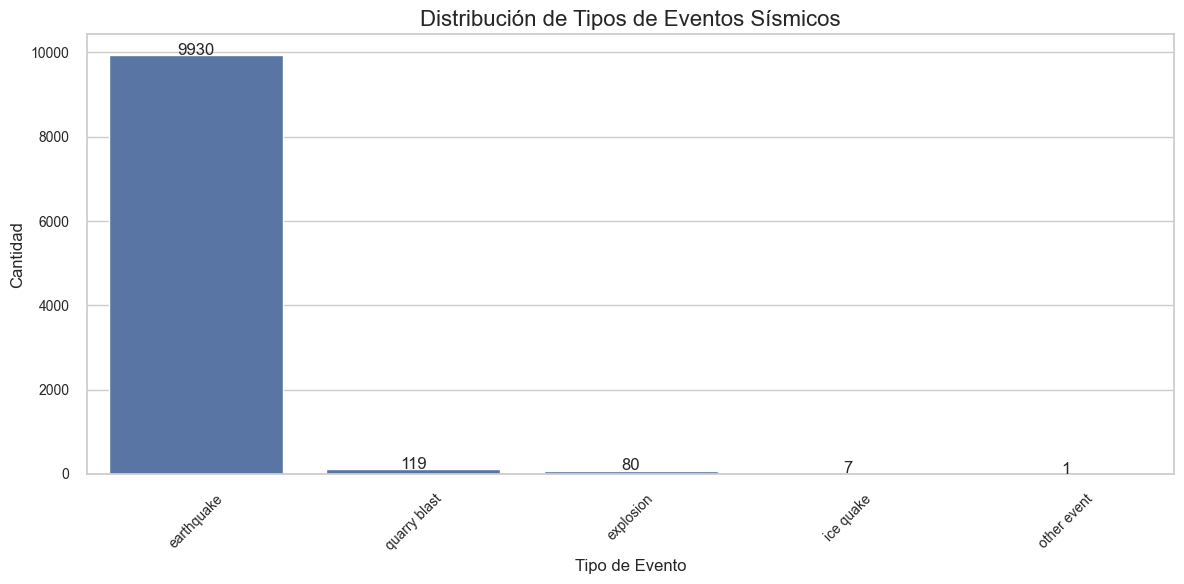

In [19]:
plt.figure(figsize=(12, 6))
tipo_counts = df_clean['type'].value_counts()
ax = sns.barplot(x=tipo_counts.index, y=tipo_counts.values)
for i, v in enumerate(tipo_counts.values):
    ax.text(i, v + 5, f"{v}", ha='center')

plt.title('Distribución de Tipos de Eventos Sísmicos', fontsize=16)
plt.xlabel('Tipo de Evento')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_tipos_eventos.png', dpi=300, bbox_inches='tight')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Crear una figura con plotly express
fig = px.bar(
    x=tipo_counts.index, 
    y=tipo_counts.values,
    labels={'x': 'Tipo de Evento', 'y': 'Cantidad'},
    title='Distribución de Tipos de Eventos Sísmicos',
    color=tipo_counts.index,
    color_discrete_sequence=px.colors.qualitative.Bold
)

# Añadir etiquetas con los valores
for i, v in enumerate(tipo_counts.values):
    fig.add_annotation(
        x=tipo_counts.index[i],
        y=v,
        text=str(v),
        showarrow=False,
        yshift=10
    )

# Personalizar la figura
fig.update_layout(
    title_font=dict(size=20),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    xaxis_tickangle=45,
    height=600,
    width=900,
    showlegend=False
)

# Mostrar la figura
fig.show()

# Guardar la figura
fig.write_html('distribucion_tipos_eventos_plotly.html')


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


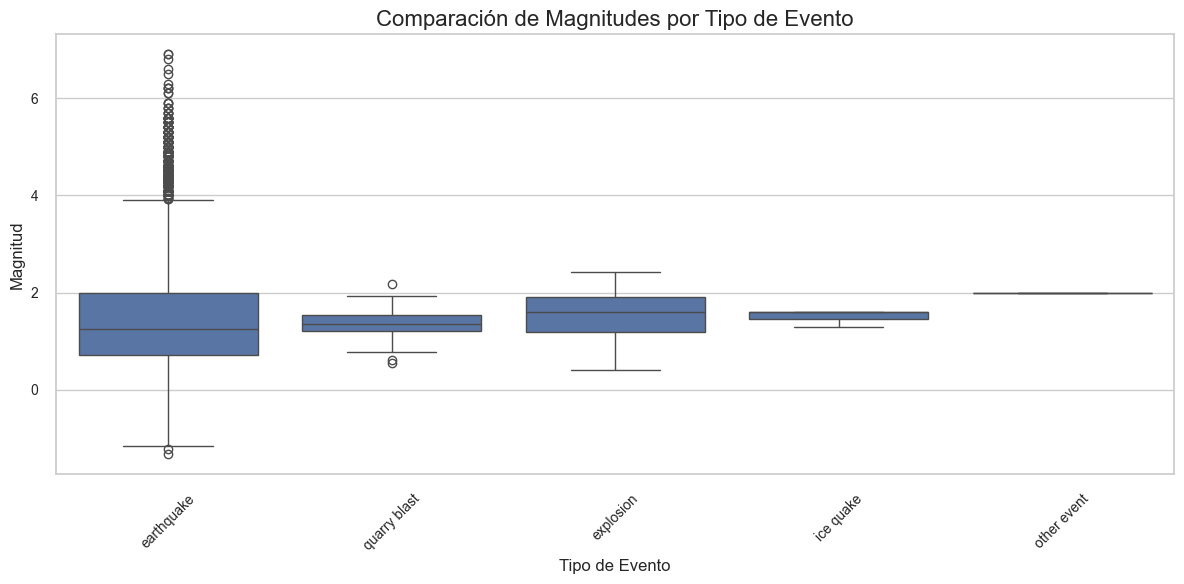

In [ ]:
# Comparar magnitudes por tipo de evento
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='mag', data=df_clean)
plt.title('Comparación de Magnitudes por Tipo de Evento', fontsize=16)
plt.xlabel('Tipo de Evento')
plt.ylabel('Magnitud')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('magnitudes_por_tipo_evento.png', dpi=300, bbox_inches='tight')

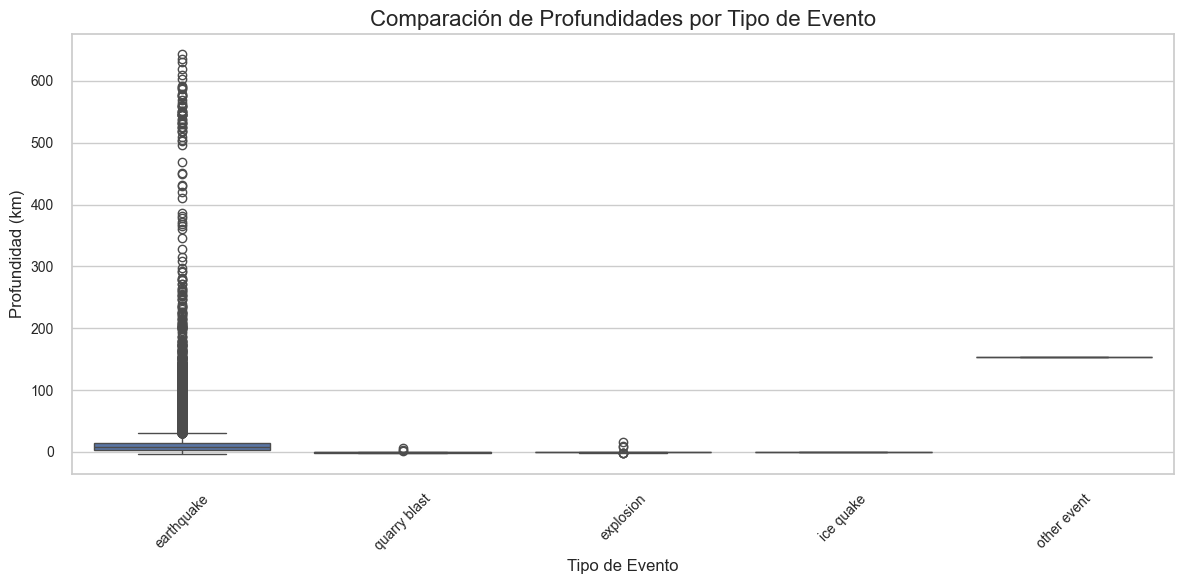

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='depth', data=df_clean)
plt.title('Comparación de Profundidades por Tipo de Evento', fontsize=16)
plt.xlabel('Tipo de Evento')
plt.ylabel('Profundidad (km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('profundidades_por_tipo_evento.png', dpi=300, bbox_inches='tight')

In [ ]:
stats_by_type = df_clean.groupby('type').agg({
    'mag': ['count', 'mean', 'median', 'min', 'max', 'std'],
    'depth': ['mean', 'median', 'min', 'max', 'std']
})

print("\nEstadísticas por tipo de evento:")
stats_by_type


Estadísticas por tipo de evento:


mag                                              depth  \
             count      mean median   min   max       std        mean   
type                                                                    
earthquake    9930  1.521051  1.250 -1.32  6.90  1.292063   20.703865   
explosion       80  1.565750  1.595  0.41  2.43  0.420752   -0.061375   
ice quake        7  1.514286  1.600  1.30  1.60  0.121499    0.000000   
other event      1  2.000000  2.000  2.00  2.00       NaN  152.800000   
quarry blast   119  1.371849  1.360  0.56  2.17  0.273799   -0.632185   

                                                   
               median     min      max        std  
type                                               
earthquake      7.580   -3.41  642.872  50.648442  
explosion      -0.445   -1.71   15.900   2.381303  
ice quake       0.000    0.00    0.000   0.000000  
other event   152.800  152.80  152.800        NaN  
quarry blast   -0.530   -2.00    5.840   1.034216

In [ ]:
# Estadísticas de magnitud
print("Estadísticas de magnitud:")
mag_stats = df_clean['mag'].describe()
print(mag_stats)

Estadísticas de magnitud:
count    10137.000000
mean         1.519695
std          1.279802
min         -1.320000
25%          0.720000
50%          1.260000
75%          1.970000
max          6.900000
Name: mag, dtype: float64


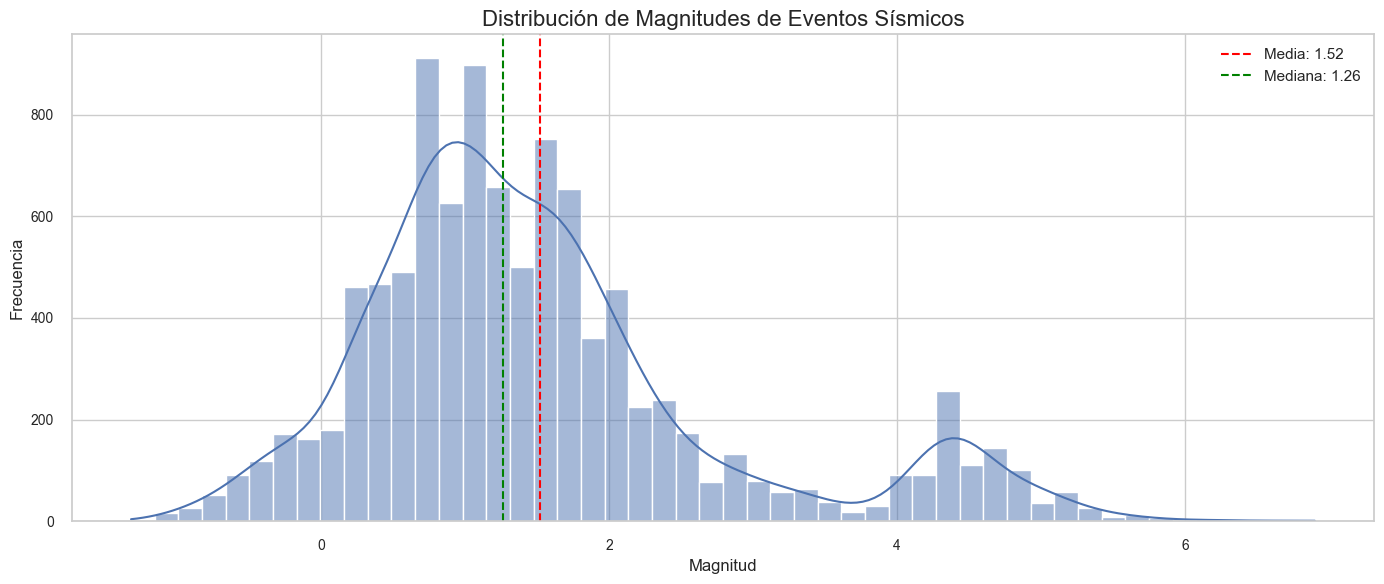

In [ ]:
# Crear figura para visualizar distribución de magnitudes
plt.figure(figsize=(14, 6))
ax = sns.histplot(df_clean['mag'], bins=50, kde=True)
plt.title('Distribución de Magnitudes de Eventos Sísmicos', fontsize=16)
plt.xlabel('Magnitud')
plt.ylabel('Frecuencia')
plt.axvline(df_clean['mag'].mean(), color='red', linestyle='--', label=f'Media: {df_clean["mag"].mean():.2f}')
plt.axvline(df_clean['mag'].median(), color='green', linestyle='--', label=f'Mediana: {df_clean["mag"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('distribucion_magnitudes.png', dpi=300, bbox_inches='tight')

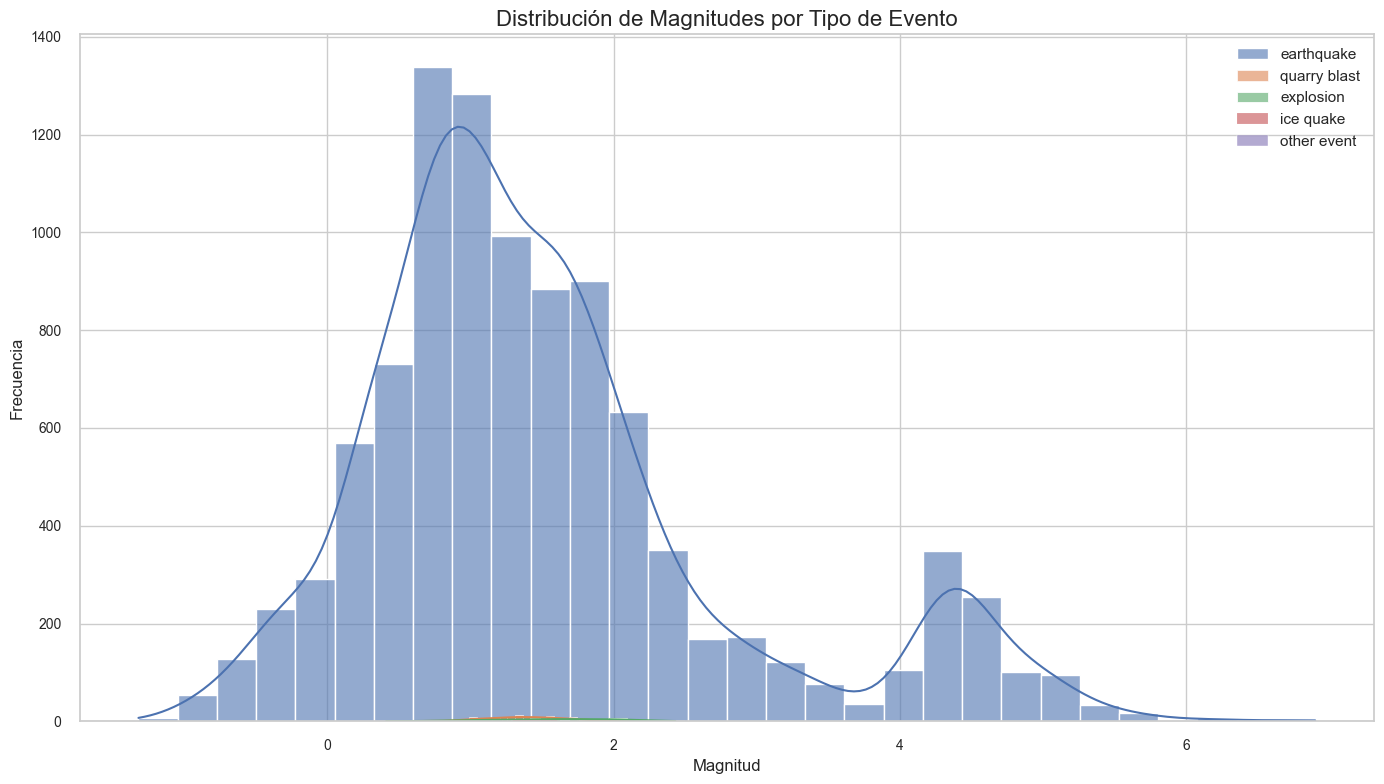

In [ ]:
# Histograma de magnitudes por tipo de evento
plt.figure(figsize=(14, 8))
for event_type in df_clean['type'].unique():
    subset = df_clean[df_clean['type'] == event_type]
    sns.histplot(subset['mag'], bins=30, kde=True, alpha=0.6, label=event_type)

plt.title('Distribución de Magnitudes por Tipo de Evento', fontsize=16)
plt.xlabel('Magnitud')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.savefig('distribucion_magnitudes_por_tipo.png', dpi=300, bbox_inches='tight')

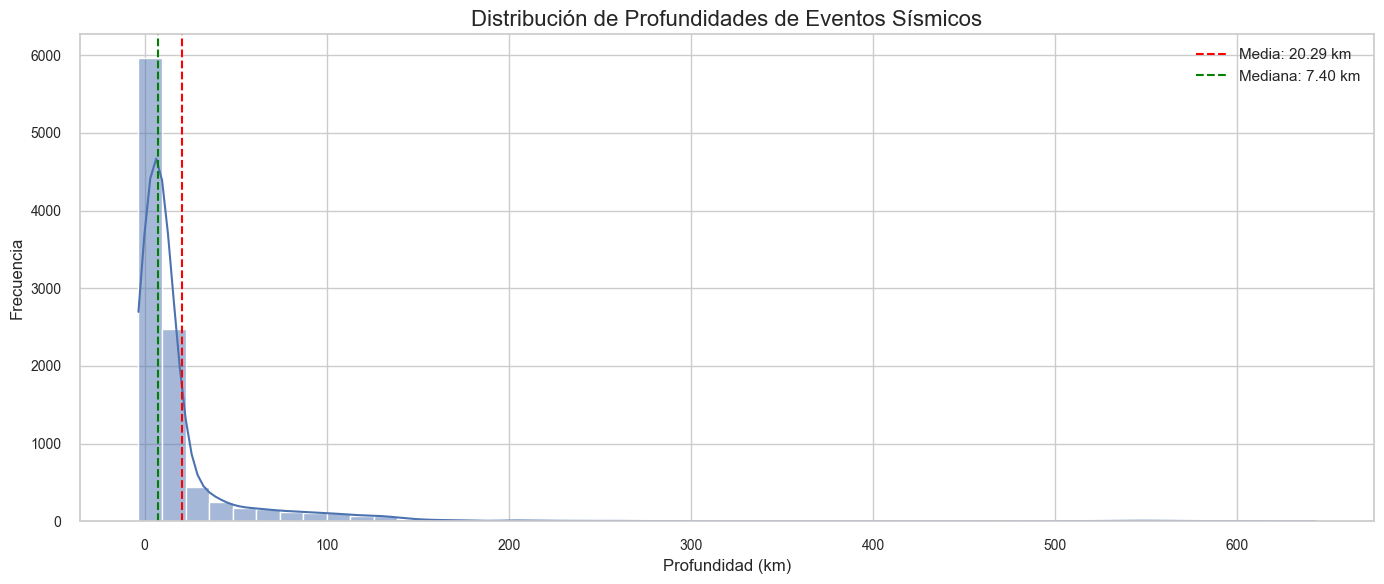

In [ ]:
# Distribución de profundidades
plt.figure(figsize=(14, 6))
sns.histplot(df_clean['depth'], bins=50, kde=True)
plt.title('Distribución de Profundidades de Eventos Sísmicos', fontsize=16)
plt.xlabel('Profundidad (km)')
plt.ylabel('Frecuencia')
plt.axvline(df_clean['depth'].mean(), color='red', linestyle='--', label=f'Media: {df_clean["depth"].mean():.2f} km')
plt.axvline(df_clean['depth'].median(), color='green', linestyle='--', label=f'Mediana: {df_clean["depth"].median():.2f} km')
plt.legend()
plt.tight_layout()
plt.savefig('distribucion_profundidades.png', dpi=300, bbox_inches='tight')

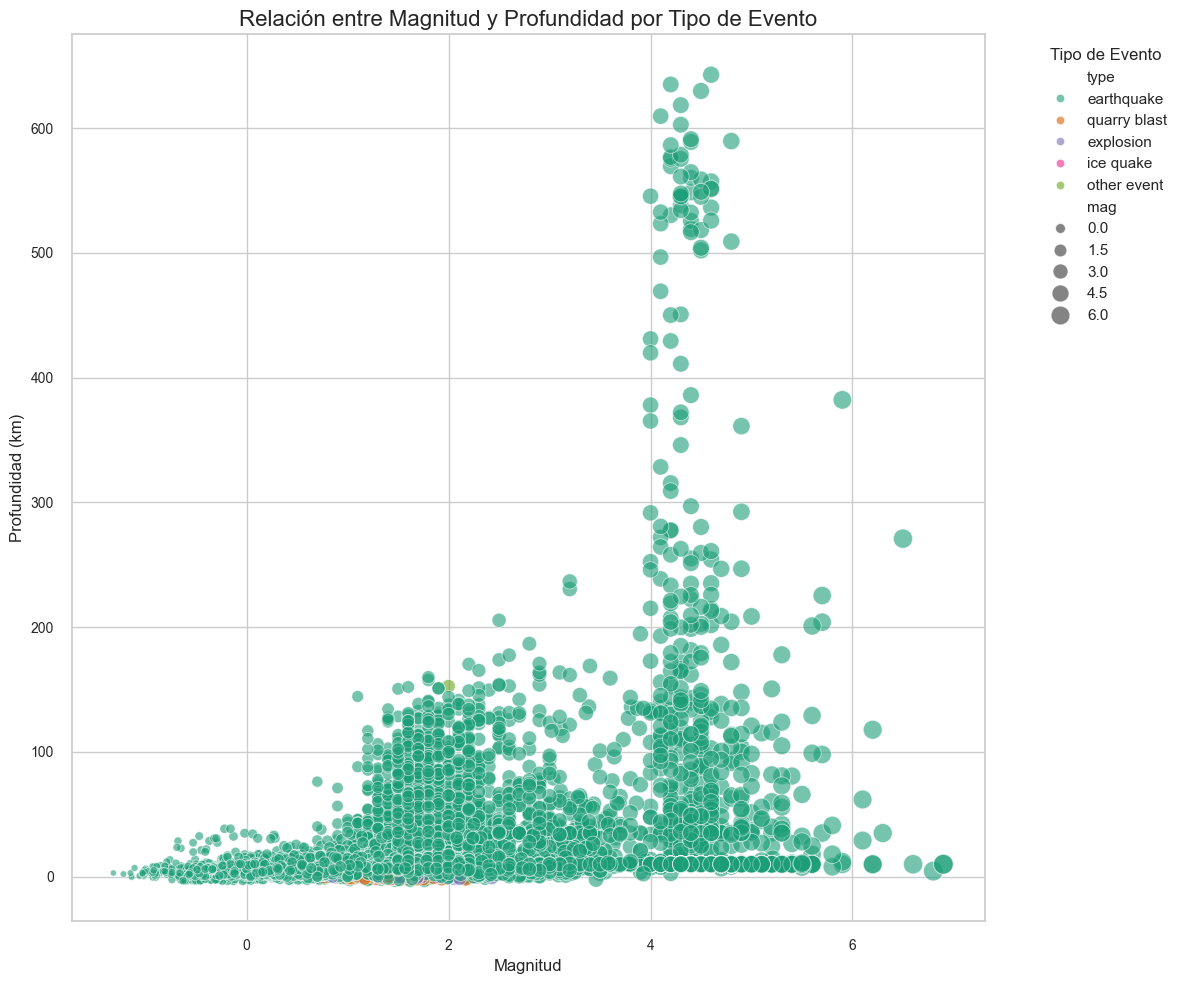

In [ ]:
# Relación entre magnitud y profundidad
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='mag', 
    y='depth', 
    hue='type',
    size='mag',
    sizes=(20, 200), 
    data=df_clean, 
    palette='Dark2',
    alpha=0.6
)
plt.title('Relación entre Magnitud y Profundidad por Tipo de Evento', fontsize=16)
plt.xlabel('Magnitud')
plt.ylabel('Profundidad (km)')
plt.legend(title='Tipo de Evento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('magnitud_vs_profundidad_por_tipo.png', dpi=300, bbox_inches='tight')


In [ ]:
#seria bueno usar las lat y long para hacer un mapa de calor de los terremotos
# Crear un mapa de calor de los terremotos
m = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=2, control_scale=True)
HeatMap(data=df_clean[['latitude', 'longitude', 'mag']], radius=15, max_zoom=13).add_to(m)
m.save('mapa_calor_terremotos.html')
m